<a href="https://colab.research.google.com/github/vinuthags/ireland-census-logistic-regression/blob/main/adversarial_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> <center><u> Adversarial Attacks on Images</u> </center></h1>
<h3 align = 'center'> Vinutha Shivakumar</h3>

In [ ]:
import tensorflow as tf
import random
# libraries for data manipulation
import numpy as np
import pandas as pd	

# libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# MNIST is an inbuilt dataset on tensorflow
mnist = tf.keras.datasets.mnist

# split the data into test and train sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# check the size of the datsets
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
# We have 60000 datapoints in train dataset and 10000 datapoints in test dataset
# each denoting pixel information of a 28 * 28 image of a handwritten number

# Normalizing the data by divinding it with 255
# The reason is because the pixel values of the image can vary between 0-255
x_train, x_test = x_train / 255.0, x_test / 255.0

<h3> EDA on MNIST Data <h3>

In [ ]:
# combine the x , y train and test arrays into pandas dataframe for EDA purpose

# unwrapping the dataset such that each row contains the pixel information of 
# each image and storing in the dataframe

# using the reshape function to convert a 3d array to 2d
# The number of rows remain same , the 28 * 28 matrix containing pixel info is
# unwrapped into a single row
mnist_train = pd.DataFrame(x_train.reshape(x_train.shape[0], 
                                           x_train.shape[1] * x_train.shape[2]))

# repeat the same for test data
mnist_test = pd.DataFrame(x_test.reshape(x_test.shape[0], 
                                           x_test.shape[1] * x_test.shape[2]))

# Create column names for dataframe to make it more readable
colnames = ['Pixel'+str(i) for i in range(1,785)]

mnist_train.columns = colnames
mnist_test.columns = colnames

# concatenate the labels into the test and train dataframe
mnist_train['label'] = y_train
mnist_test['label'] = y_test


mnist_train.head()

,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,Pixel9,Pixel10,...,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783,Pixel784,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [ ]:
mnist_test.head()

,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,Pixel9,Pixel10,...,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783,Pixel784,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [ ]:
# check if there is any NaN or missing datapoints
mnist_train.isnull().values.sum()

0

[Text(0.5, 1.0, 'Label distribution in Training Data')]

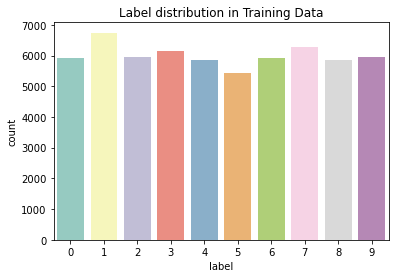

In [ ]:
# check label distribution in test and train datasets
sns.countplot(x="label", data=mnist_train, palette="Set3").set(
    title="Label distribution in Training Data")

[Text(0.5, 1.0, 'Label distribution in Test Data')]

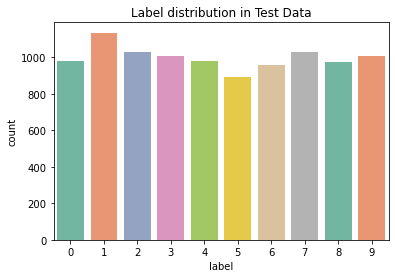

In [ ]:
sns.countplot(x="label", data=mnist_test, palette="Set2").set(
    title="Label distribution in Test Data")

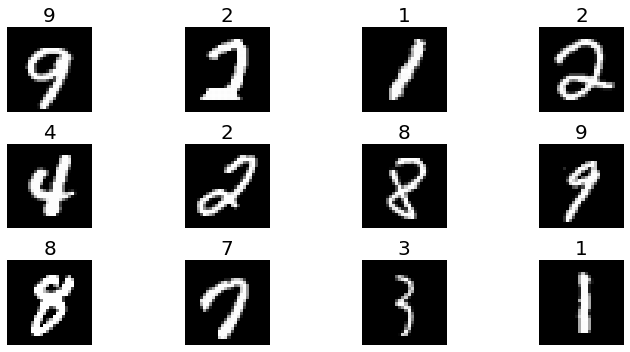

In [ ]:
# visualise some of the images from train dataset
# display 4 images per row
fig, axes = plt.subplots(3,4, figsize=(10,5))
# set a tight layout for better spacing between plots
fig.tight_layout()
axes = axes.flatten()
# generate 12 random row numbers to select from mnist_train dataframe
idx = np.random.randint(0,mnist_train.shape[0],size=12)
for i in range(12):
    # get the row data
    pixel_data = mnist_train.iloc[idx[i]]
    # use imshow to build the image using pixel info
    # reshape is necessary because imshow expects a 2d array structure as input
    axes[i].imshow(np.array(pixel_data[:784]).reshape(28,28), cmap='gray')
    axes[i].axis('off') 
    # add the label of the image as title
    axes[i].set_title(str(int(pixel_data[-1])), color= 'black', fontsize=20)
    

<h3> Models <h/3>
    <h4> XGBOOST </h4>

In [ ]:
import xgboost as xb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# splitting the training data into train and validate datasets
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train, 
                                                  test_size=0.1)

# All the numpy array structures need to be transformed to DMatrix structure
# which is optimized specifically for XGBoost models
# reshaping the x_train, x_val and x_test to a 2d matrix
xgb_train_matrix = xb.DMatrix(x_train.reshape(x_train.shape[0], 
                                    x_train.shape[1] * x_train.shape[2]), 
                              label=y_train)

xgb_val_matrix = xb.DMatrix(x_val.reshape(x_val.shape[0], 
                                    x_val.shape[1] * x_val.shape[2]), 
                              label=y_val)

xgb_test_matrix = xb.DMatrix(x_test.reshape(x_test.shape[0], 
                                    x_test.shape[1] * x_test.shape[2]), 
                              label=y_test)

# set the hyperparameters for the model
params = {
    'max_depth': 10,                # the maximum depth of each tree
    'eta': 0.7,                     # the training step for each iteration
    'objective': 'multi:softmax',   # multiclass classification using the softmax objective
    'num_class': 10,                # labels range from 0-9 hence the num_classes is 10
    'eval_metric': ['merror' ,      # evaluation metric as mean squared error
                    'mlogloss']     # and log loss
}  

results = {}
xgb_model = xb.train(params, xgb_train_matrix, evals=[(xgb_train_matrix, 'train'),
                                                      (xgb_val_matrix, 'val')],
                     num_boost_round=10,
                     evals_result = results,
                     verbose_eval=True)

y_pred = xgb_model.predict(xgb_test_matrix)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	train-merror:0.05859	train-mlogloss:0.43100	val-merror:0.10833	val-mlogloss:0.56329
[1]	train-merror:0.02363	train-mlogloss:0.23462	val-merror:0.07750	val-mlogloss:0.40250
[2]	train-merror:0.01276	train-mlogloss:0.13570	val-merror:0.06633	val-mlogloss:0.30869
[3]	train-merror:0.00700	train-mlogloss:0.08137	val-merror:0.05967	val-mlogloss:0.25180
[4]	train-merror:0.00328	train-mlogloss:0.05043	val-merror:0.05600	val-mlogloss:0.21575
[5]	train-merror:0.00152	train-mlogloss:0.03216	val-merror:0.05183	val-mlogloss:0.19009
[6]	train-merror:0.00083	train-mlogloss:0.02176	val-merror:0.04883	val-mlogloss:0.17289
[7]	train-merror:0.00033	train-mlogloss:0.01523	val-merror:0.04600	val-mlogloss:0.16153
[8]	train-merror:0.00015	train-mlogloss:0.01096	val-merror:0.04500	val-mlogloss:0.15310
[9]	train-merror:0.00009	train-mlogloss:0.00816	val-merror:0.04233	val-mlogloss:0.14553
Accuracy: 95.94%


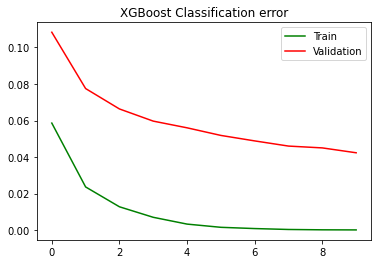

In [ ]:
epochs = range(len(results['train']['merror']))

plt.plot(epochs,results['train']['merror'], color='green', label='Train' )
plt.plot(epochs,results['val']['merror'], color='red', label='Validation' )
plt.title('XGBoost Classification error')
plt.legend()
plt.show()

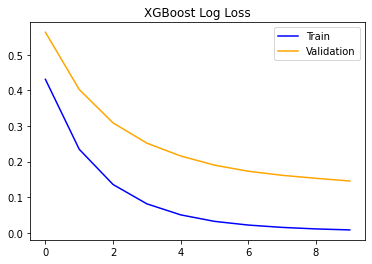

In [ ]:
plt.plot(epochs,results['train']['mlogloss'], color='blue', label='Train' )
plt.plot(epochs,results['val']['mlogloss'], color='orange', label='Validation' )
plt.title('XGBoost Log Loss')
plt.legend()
plt.show()

<h4> CNN </h4>

In [ ]:
from keras.utils.np_utils import to_categorical  # convert to one-hot-encoding
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose
from keras import optimizers
from keras import models

In [ ]:
# add a channel dimension to the images
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_val= np.expand_dims(x_val, axis=-1)

# one hot encoding all the labels
y_train = to_categorical(y_train,10)
y_test = to_categorical(y_test,10)
y_val = to_categorical(y_val,10)

cnn_model = models.Sequential()

cnn_model.add(Conv2D(filters=20, kernel_size=(5, 5), 
                   activation='relu', padding="same", 
                   input_shape=(28,28,1)))
cnn_model.add(BatchNormalization(axis=-1))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(filters=20, kernel_size=(4, 4), 
                   activation='relu', padding="same"))
cnn_model.add(BatchNormalization(axis=-1))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(filters=20, kernel_size=(4, 4), 
                   activation='relu', padding="same"))
cnn_model.add(BatchNormalization(axis=-1))
cnn_model.add(Dropout(0.2))

cnn_model.add(Flatten())
cnn_model.add(Dense(200, activation='relu'))

cnn_model.add(Dense(10, activation='softmax'))

cnn_model_opt = optimizers.Adam(decay=1e-4)

print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 20)        520       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 20)       80        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 28, 28, 20)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 20)        6420      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 20)       80        
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 20)        0

In [ ]:
cnn_model.compile(optimizer = cnn_model_opt , loss = "categorical_crossentropy", 
                  metrics=["accuracy"]) 

cnn_model_fit = cnn_model.fit(x_train, 
                        y_train,
                        validation_data = (x_val, y_val),
                        batch_size=128,
                        epochs=10)

cnn_test_accuracy = cnn_model.evaluate(x_test, y_test)
print("Accuracy on test data is : ", cnn_test_accuracy[1] * 100)

Epoch 1/2
422/422 [==============================] - 113s 266ms/step - loss: 0.1815 - accuracy: 0.9511 - val_loss: 0.5136 - val_accuracy: 0.8113
Epoch 2/2
313/313 [==============================] - 4s 13ms/step - loss: 0.0506 - accuracy: 0.9846
Accuracy on test data is :  98.46000075340271


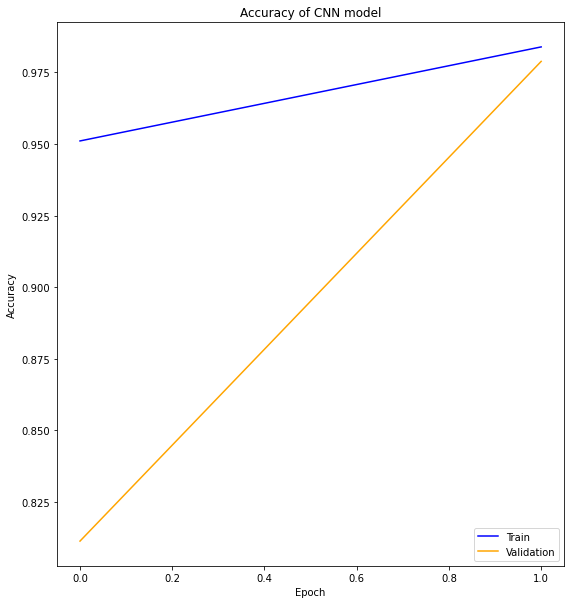

In [ ]:
plt.figure(figsize=(20,10))
# plot the accuracy for the train and validation datset
plt.subplot(1,2,1)
plt.plot(cnn_model_fit.history['accuracy'], color='blue', 
         label="Training accuracy")
plt.plot(cnn_model_fit.history['val_accuracy'], color='orange', 
         label="Validation accuracy")
plt.title("Accuracy of CNN model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="lower right")

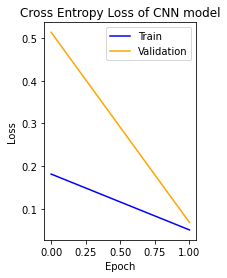

In [ ]:
# plot the loss of train and validation dataset
plt.subplot(1,2,2)
plt.plot(cnn_model_fit.history['loss'], color='blue', 
         label="Training loss")
plt.plot(cnn_model_fit.history['val_loss'], color='orange', 
         label="Validation loss")
plt.title("Cross Entropy Loss of CNN model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")

In [ ]:
# visualising examples that are misclassified
y_test_pred = cnn_model.predict(x_test)
errors = np.absolute(y_test_pred - y_test)
errors = [np.round(np.sum(each)) for each in errors]

# check the unique error values generated
set(errors)

313/313 [==============================] - 5s 15ms/step


{0.0, 1.0, 2.0}

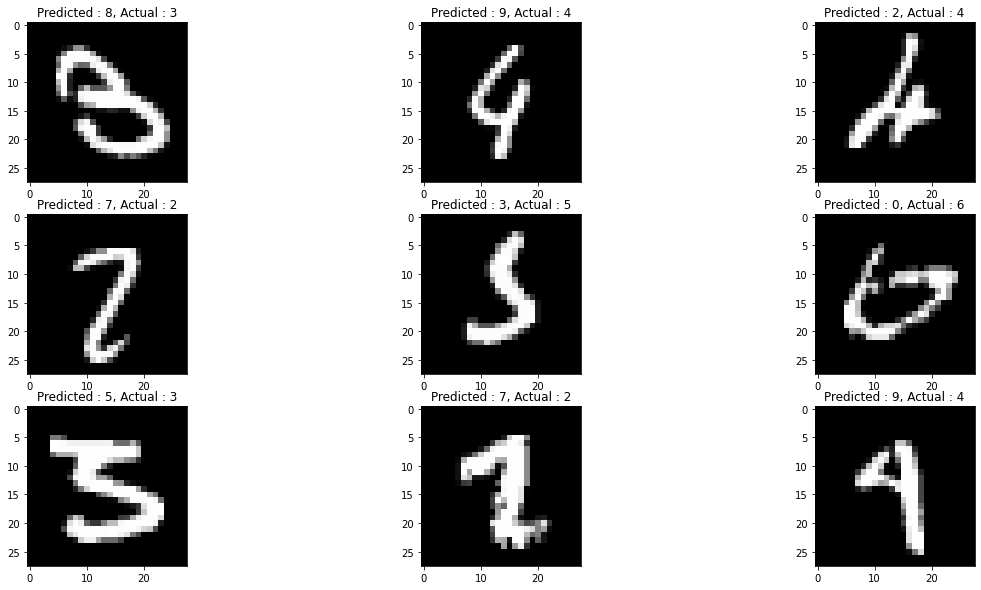

In [ ]:
# since 2 is the max error difference i will fetch these indices
# and check if the index with maxvalue match in our prediction and test label
# fetching the max value because of one hot encoding
error_index = [i for i, x in enumerate(errors) if (x==2.0 and 
                                                       (np.argmax(y_test_pred[i])
                                                        !=
                                                        np.argmax(y_test[i])))]

# plot the images
plt.figure(figsize=(20,10))
for i,index in enumerate(error_index[:9]):
    plt.subplot(3,3,i+1)
    plt.title("Predicted : {}, Actual : {}".format(np.argmax(y_test_pred[index]),
                                                   np.argmax(y_test[index])))
    plt.imshow(np.reshape(x_test[index],(28,28)), cmap="gray")

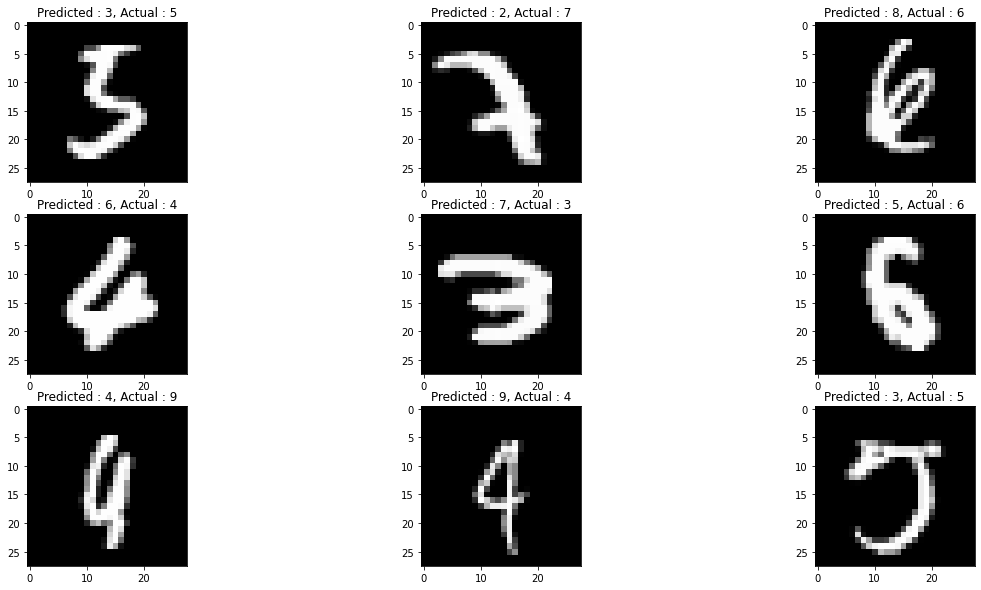

In [ ]:
# repeating the same steps as above where error difference is 1.0
error_index = [i for i, x in enumerate(errors) if (x==1.0 and 
                                                       (np.argmax(y_test_pred[i])
                                                        !=
                                                        np.argmax(y_test[i])))]

# plot the images
plt.figure(figsize=(20,10))
for i,index in enumerate(error_index[:9]):
    plt.subplot(3,3,i+1)
    plt.title("Predicted : {}, Actual : {}".format(np.argmax(y_test_pred[index]),
                                                   np.argmax(y_test[index])))
    plt.imshow(np.reshape(x_test[index],(28,28)), cmap="gray")

<h3> Adversarial Attacks </h3>
<h4> FGSM </h4>

1/1 [==============================] - 0s 25ms/step


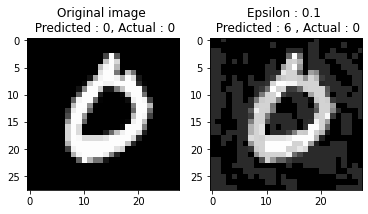

1/1 [==============================] - 0s 22ms/step


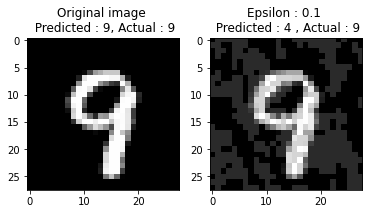

1/1 [==============================] - 0s 26ms/step


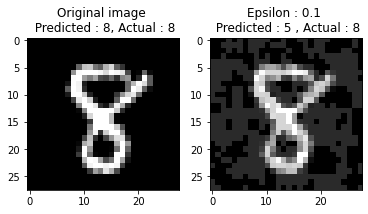

1/1 [==============================] - 0s 26ms/step


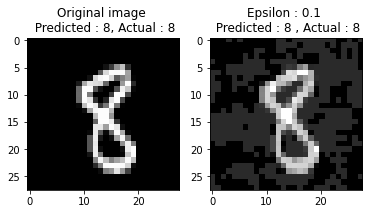

1/1 [==============================] - 0s 24ms/step


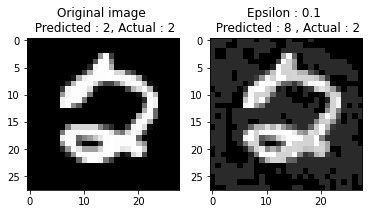

In [ ]:
# fetching all the test cases which have been predicted correctly by the model
# I will be creating adversarial examples on these image data to show how
# different types of attack confuse the neural network and misclassify the image
index_correctly_classified = [i for i, x in enumerate(errors) if (x==0.0 and 
                                                       (np.argmax(y_test_pred[i])
                                                        ==
                                                        np.argmax(y_test[i])))]

x_test_correctly_classified = x_test[index_correctly_classified]
y_test_correctly_classified = y_test[index_correctly_classified]

loss_object = tf.keras.losses.CategoricalCrossentropy()
def FGSM(model, image, label, eps):
	# cast the image to float object
	image = tf.cast(image, tf.float32)
    # as tensorflow to start recording gradients of image
	with tf.GradientTape() as tape:
		tape.watch(image)
        # use model predictions to obtain loss
		pred = model(image)
		loss = loss_object(label, pred)
    # calculate gradients of loss wrt the original image
	gradient = tape.gradient(loss, image)
    # get the sign of gradients which will be a vector of -1,1 or 0
	signed_grad = tf.sign(gradient)
	# update the original image with the signed gradients
    # using a small epsilon will ensure that the changes to image
    # arent visible to human eye
	adversary = (image + (signed_grad * eps)).numpy()
	return adversary

# randomly select 5 images and run fgsm attacks on them
for i in random.sample(range(0, x_test_correctly_classified.shape[0]),5):
    image = x_test_correctly_classified[i].reshape(1,28,28,1)
    label = y_test_correctly_classified[i].reshape(1,10)
    perturbed_image = FGSM(cnn_model,image, label,eps=0.1)
    predicted_label = np.argmax(cnn_model.predict(perturbed_image))
    actual_label = np.argmax(label)
    plt.figure()
    plt.subplot(1,2,1)
    plt.title("Original image \n Predicted : {}, Actual : {}".format(np.argmax(label),
                                                   actual_label))
    plt.imshow(np.reshape(x_test_correctly_classified[i],(28,28)), cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(perturbed_image[0]*0.5+0.5, cmap="gray")
    plt.title("Epsilon : 0.1 \n Predicted : {} , Actual : {}".format(
                                                            predicted_label,
                                                            actual_label))
    plt.show()

<h4> Deepfool Attack </h4>

8229
7710
743
687
4188


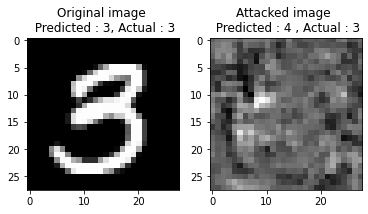

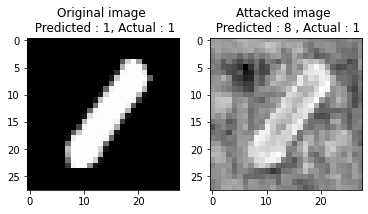

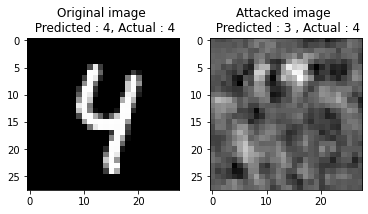

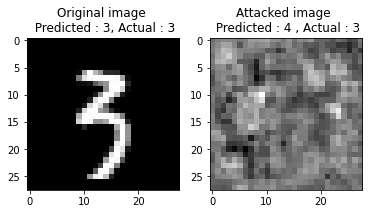

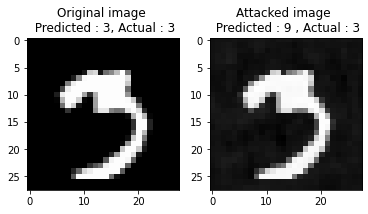

In [ ]:
def DeepFool(image, model):
    # cast image to float
    image = tf.cast(image , tf.float32)
    adversary= image
    x = tf.Variable(adversary)
    fs = model(x)
    # the model gives probabilities associated with each label
    # we sort them in descending order and store the indexes
    # this is useful for projecting the image onto the hyperplane of the 
    # next closest label prediction to check if it confuses the model
    label_list = np.argsort(fs)[0][::-1]
    actual_label = label_list[0]
    
    # set the initial gradient change to 0 
    w = np.zeros(np.shape(image))
    # perturbation to image is also set to 0
    r_tot = np.zeros(np.shape(image))

    iteration = 0
    
    # the initial label will be the same as actual label
    k_i = actual_label
    
    # keep looping until there is a change in label prediction upto 50 iterations
    while (k_i == actual_label and iteration < 50):
        # initial perturbation is set to infinity as we want to find
        # the minimum perturbartion to image to misclassify
        pert = np.inf
        # start recording gradient of image
        with tf.GradientTape() as tape:
            tape.watch(x)
            fs = model(x)
            # the loss here taken as the logits probability of the actual label
            loss = fs[0, label_list[0]]
        # get the gradient of loss wrt image
        grad_orig = tape.gradient(loss, x)
        
        # start checking which projection gives least perturbation
        for k in range(1, 10):
            with tf.GradientTape() as tape:
                tape.watch(x)
                fs = model(x)
                # get the logit prob wrt the label we are iteration over
                loss = fs[0, label_list[k]]
            # get gradient of loss wrt image over the new label
            cur_grad = tape.gradient(loss, x)
            
            # check if there is any difference in gradients
            w_k = cur_grad - grad_orig
            
            # change in logits probability
            f_k = (fs[0, label_list[k]] - fs[0, label_list[0]]).numpy()
            
            try:
                # np.linalg.norm without any arguments defaults to 2-norm
                pert_k = abs(f_k) / np.linalg.norm(tf.reshape(w_k, [-1]))
            except ZeroDivisionError:
                # if there is near 0 change in gradient move on to next label
                # to avoid division by zero error
                break
            
            # update to lowest perturbation and gradient
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # calculate minimal vector that projects onto the hyperplane with
        # minimal perturbation
        r_i = pert  * w / np.linalg.norm(w)
        # acumulate the vector of perturbation every iteration
        r_tot = np.float32(r_tot + r_i)
        # add perturbation to image
        adversary = image +r_tot
        
        # update the image to adversary
        x = tf.Variable(adversary)
        
        # get new  predictions after adding perturbations
        fs = model(x)
        k_i = np.argmax(np.array(fs).flatten())

        iteration += 1


    return k_i, adversary   

# Deepfool attack on MNIST dataset distorts the data in such a way that is even 
# visible to human eye, this attack when run on other datasets which are much bigger
# and have a good amount of RGB data like CIFAR-10 the image distortions arent as evident 
# as the MNIST distprtions. Proof of this will be attached in the report 
for i in random.sample(range(0, x_test_correctly_classified.shape[0]),5):                
    image = np.reshape(x_test_correctly_classified[i] , (1,28,28,1))
    label = cnn_model(image)	
    actual_label = np.argmax(label)
    label_pert, pert_image = DeepFool(image, cnn_model)
    plt.figure()
    plt.subplot(1,2,1)
    plt.title("Original image \n Predicted : {}, Actual : {}".format(np.argmax(label),
                                                   actual_label))
    plt.imshow(np.reshape(x_test_correctly_classified[i],(28,28)), cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(pert_image[0],(28,28)) ,cmap="gray")
    plt.title("Attacked image \n Predicted : {} , Actual : {}".format(
                                                            label_pert,
                                                            actual_label))

<h4> LBFGS </h4>

Evaluation took: 4.576158 seconds
1/1 [==============================] - 0s 17ms/step


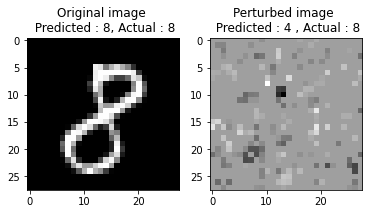

Evaluation took: 2.006166 seconds
1/1 [==============================] - 0s 20ms/step


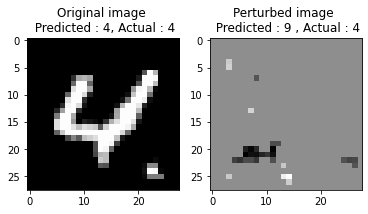

Evaluation took: 3.852556 seconds
1/1 [==============================] - 0s 18ms/step


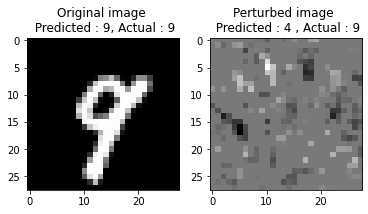

Evaluation took: 3.826528 seconds
1/1 [==============================] - 0s 17ms/step


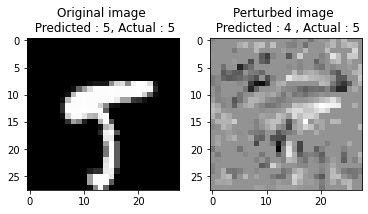

Evaluation took: 3.640390 seconds
1/1 [==============================] - 0s 18ms/step


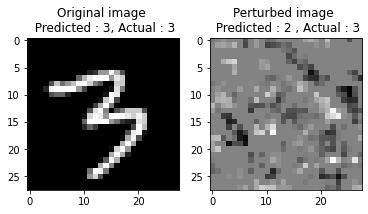

In [ ]:
import tensorflow_probability as tfp
import contextlib
import time

# The below functions(np_value, timed_execution and run) are used to extract the 
# minimized gradients from the lbfgs optimizer
def np_value(tensor):
  """Get numpy value out of possibly nested tuple of tensors."""
  if isinstance(tensor, tuple):
    return type(tensor)(*(np_value(t) for t in tensor))
  else:
    return tensor.numpy()

@contextlib.contextmanager
def timed_execution():
  t0 = time.time()
  yield
  dt = time.time() - t0
  print('Evaluation took: %f seconds' % dt)
  
def run(optimizer):
  """Run an optimizer and measure it's evaluation time."""
  optimizer()  # Warmup.
  with timed_execution():
    result = optimizer()
  return np_value(result)

  
def lbfgs(model, image, actual_label):
    image = tf.cast(image, tf.float32)
    # initial guess
    # the noise will be 0
    x0 = np.zeros(np.prod(image.shape), dtype="float32").reshape(1,28,28,1)	
    # the function to be minimized by the lbfgs optimzer
    # using the gradient tape to keep track of the gradients of image
    # and obtaining the loss and associated gradient of image that has
    # some noise added to it
    def loss_grad(params):
        adversary = tf.cast(image+params,tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(adversary)
            # use model predictions to obtain loss
            pred = model(adversary)
            loss = pred[0, actual_label]
        # calculate gradients of loss wrt the original image
        gradient = tf.cast(tape.gradient(loss, adversary), tf.float32)
        return loss, gradient
    
    # call the optimizer function
    def optim():
        return tfp.optimizer.lbfgs_minimize(loss_grad,
                                     initial_position=x0,
                                     tolerance=1e-08)
    # runs the lbfgs optimizers and
    # extracts the tensors containing the minimal gradient change which
    # will convert the image to an adversarial example
    res = run(optim)
    # the .position gives access to the tensor with minimum gradient value
    # use this to add noise to original image
    adversary = image + res.position
    return adversary

# randomly select 5 images and run fgsm attacks on them
for i in random.sample(range(0, x_test_correctly_classified.shape[0]),5):
    image = x_test_correctly_classified[i].reshape(1,28,28,1)
    label = y_test_correctly_classified[i].reshape(1,10)
    actual_label = np.argmax(label)
    perturbed_image = lbfgs(cnn_model,image,actual_label)
    predicted_label = np.argmax(cnn_model.predict(perturbed_image))
    plt.figure()
    plt.subplot(1,2,1)
    plt.title("Original image \n Predicted : {}, Actual : {}".format(np.argmax(label),
                                                   actual_label))
    plt.imshow(np.reshape(x_test_correctly_classified[i],(28,28)), cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(perturbed_image[0]*0.5+0.5, cmap="gray")
    plt.title("Perturbed image \n Predicted : {} , Actual : {}".format(
                                                            predicted_label,
                                                            actual_label))
    plt.show()

<h3> Defence against Adversarial Attack </h3>
<h4> Adversarial Training on FGSM</h4>

In [ ]:
def create_fgsm_examples(model):
    while True:
        adversary_images = []
        adversary_label = []
        # train on over 5000 adversarial images
        index  = random.sample(range(0,x_test.shape[0]), 5000)
        for i in index:
            image = x_test[i].reshape(1,28,28,1)
            label = y_test[i].reshape(1,10)
            adversary = FGSM(model,image, label,eps=0.1)
            # store the perturbed image into the list
            adversary_images.append(adversary.reshape(28,28,1))
            # we use the original label associated with it and store that
            # into the adversary label list
            adversary_label.append(y_test[i])
    
        yield (np.array(adversary_images), np.array(adversary_label))

(advX, advY) = next(create_fgsm_examples(cnn_model))
(loss, acc) = cnn_model.evaluate(x=advX, y=advY, verbose=0)
print("[INFO] adversarial testing images:")
print("[INFO] loss: {:.4f}, acc: {:.4f}\n".format(loss, acc))

print("[INFO] re-compiling model...")
cnn_model.compile(optimizer = cnn_model_opt , loss = "categorical_crossentropy", 
                  metrics=["accuracy"]) 
# fine-tune our CNN on the adversarial images
print("[INFO] fine-tuning network on adversarial examples...")
cnn_model.fit(advX, advY,
              batch_size=128,
              epochs=10)

(loss, acc) = cnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print("")
print("[INFO] normal testing images *after* fine-tuning:")b
print("[INFO] loss: {:.4f}, acc: {:.4f}\n".format(loss, acc))
# do a final evaluation of the model on the adversarial images
(loss, acc) = cnn_model.evaluate(x=advX, y=advY, verbose=0)
print("[INFO] adversarial images *after* fine-tuning:")
print("[INFO] loss: {:.4f}, acc: {:.4f}".format(loss, acc))

[INFO] adversarial testing images:
[INFO] loss: 6.0263, acc: 0.2372

[INFO] re-compiling model...
[INFO] fine-tuning network on adversarial examples...
Epoch 1/10
40/40 [==============================] - 11s 261ms/step - loss: 0.4318 - accuracy: 0.8972
Epoch 2/10
40/40 [==============================] - 10s 262ms/step - loss: 0.0430 - accuracy: 0.9872
Epoch 3/10
40/40 [==============================] - 10s 248ms/step - loss: 0.0057 - accuracy: 0.9980
Epoch 4/10
40/40 [==============================] - 10s 247ms/step - loss: 0.0019 - accuracy: 0.9996
Epoch 5/10
40/40 [==============================] - 10s 246ms/step - loss: 7.2200e-04 - accuracy: 1.0000
Epoch 6/10
40/40 [==============================] - 10s 247ms/step - loss: 4.1070e-04 - accuracy: 1.0000
Epoch 7/10
40/40 [==============================] - 10s 246ms/step - loss: 2.8633e-04 - accuracy: 1.0000
Epoch 8/10
40/40 [==============================] - 10s 252ms/step - loss: 2.5904e-04 - accuracy: 1.0000
Epoch 9/10
40/40 [======

<h4> DCGAN </h4>

In [ ]:
# create the generator model
def generator_model():
    gen_model = models.Sequential()
    gen_model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    gen_model.add(BatchNormalization())
    gen_model.add(LeakyReLU())
    
    gen_model.add(Reshape((7, 7, 256)))
    assert gen_model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    gen_model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert gen_model.output_shape == (None, 7, 7, 128)
    gen_model.add(BatchNormalization())
    gen_model.add(LeakyReLU())
    
    gen_model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), 
                                  padding='same', use_bias=False))
    assert gen_model.output_shape == (None, 14, 14, 64)
    gen_model.add(BatchNormalization())
    gen_model.add(LeakyReLU())

    gen_model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2),
                                  padding='same', use_bias=False, 
                                  activation='tanh'))
    return gen_model

# create the discriminator model
def discriminator_model():
    disc_model = models.Sequential()
    disc_model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    disc_model.add(LeakyReLU())
    disc_model.add(Dropout(0.2))

    disc_model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    disc_model.add(LeakyReLU())
    disc_model.add(Dropout(0.2))

    disc_model.add(Flatten())
    disc_model.add(Dense(512))
    disc_model.add(LeakyReLU())
    disc_model.add(Dense(1))
    
    return disc_model

generator = generator_model()
discriminator = discriminator_model()